<a class="anchor" id="up-bullet"></a>

# Generation of Synthetic Sonic Log Data Using Random Forest Algorithm at the Lagoa Parda Field in Espirito Santo, Brasil

* __Author__: Gabriel Senra
* __Date__: 10/02/2022


- [1. Introduction: Synthetic Sonic Curves Generation](#first-bullet)
    - [1.1. Background](#first1-bullet)
    - [1.2. Problem Statement](#first2-bullet)
    - [1.3. Data Description](#first3-bullet)
    - [1.4. Evaluation Metric](#first4-bullet)
    - [1.5. Base Line](#first5-bullet)


- [2. Imports](#second-bullet)


- [3. Methods](#thrid-bullet)


- [4. Split DataSets](#fourth-bullet)


- [5. Data Cleaning](#fifth-bullet)


- [6. Build Machine Learning Models](#sixth-bullet)


- [7. References](#seventh-bullet)    

<a class="anchor" id="first1-bullet"></a>

## 1.1. Background

Well logs are interpreted/processed to estimate the in-situ petrophysical and geomechanical properties, which is essential for subsurface characterization. Various types of logs exist, and each provides distinct information about subsurface properties. Certain well logs, like gamma ray (GR), resistivity, density, and neutron logs, are considered as “easy-to-acquire” conventional well logs that are run in most of the wells. Other well logs, like nuclear magnetic resonance, dielectric dispersion, elemental spectroscopy, and sometimes sonic logs, are only run in limited number of wells.

Sonic travel-time logs contain critical geomechanical information for subsurface characterization around the wellbore. Often, sonic logs are required to complete the well-seismic tie workflow or geomechanical properties prediction. When sonic logs are absent in a well or an interval, a common practice is to synthesize them based on its neighboring wells that have sonic logs. This is referred to as sonic log synthesis or pseudo sonic log generation.

<a class="anchor" id="first2-bullet"></a>

## 1.2. Problem Statement

 Compressional travel-time (DT) logs are not acquired in all the wells drilled in a field due to financial or operational constraints. Under such circumstances, machine learning techniques can be used to predict DT logs to improve subsurface characterization. The goal of the study is to develop data-driven models by processing “easy-to-acquire” conventional logs from a list of weels, and use the data-driven models to generate synthetic compressional logs (DT) in rest of Wells. A robust data-driven model for the desired sonic-log synthesis will result in low prediction errors, which can be quantified in terms of Root Mean Squared Error by comparing the synthesized and the original DT logs.

 Our goal is to build a generalizable data-driven models using train dataset. Following that, the program deploy the newly developed data-driven models on test dataset to predict DT logs. The data-driven model should use feature sets derived from the following 6 logs: NPHI, GR, CALI, DEPT, RHOB, ILD. The data-driven model should synthesize the target logs: DT.

<a class="anchor" id="first3-bullet"></a>

## 1.3. Data Decription 

- Curve: DEPT, Units: M, Description: Measured Depth
- Curve: CALI, Units: in, Description: CALIPER
- Curve: DT, Units: us/ft, Description: DELTA-T (ALSO CALLED SLOWNESS OR INTERVAL TRANSIT TIME)
- Curve: GR, Units: gAPI, Description: GAMMA RAY
- Curve: RHOB, Units: g/cm3, Description: BULK DENSITY
- Curve: NPHI, Units: %, Description: THERMAL NEUTRON POROSITY (ORIGINAL RATIO METHOD) IN SELECTED LITHOLOGY
- Curve: ILD, Units: ohm.m, Description: INDUCTION DEEP RESISTIVITY

<a class="anchor" id="first4-bullet"></a>

## 1.4. Evaluation Metric

We will be evaluated by the metirc Root Mean Squared Error and r².

### The RMSE is calculated as:

### RMSE = $\sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}}$

Where:

- "di" is the predicted curve for DT
- "fi" is the true value for evaluation.

### R² (Variance Explained) is calculated as:

## $R^2 = \frac {{SS}_{regression}}{{SS}_{total}} = 1 - \frac{\sum_{i}({y}_{i} - \hat{y}_{i})^2}{\sum_{i}({y}_{i} - \bar{y}_{i})^2}$

Where:

- Yi is the predicted curve for DT
- Ŷi is the mean value of predicted curve for DT
- Ȳi is the mean value for true DT

DT are in the same weight during the evaluation

Understanding and optimizing your predictions for this evaluation metric is paramount for this inference.

<a class="anchor" id="first5-bullet"></a>

## 1.5. Base Line

### Faust's Equation = $\frac{1000}{({2*DEPT*ILD})^{\frac{1}{6}}}$

<a class="anchor" id="first6-bullet"></a>

<a class="anchor" id="second-bullet"></a>

[Up](#up-bullet)

# 2. Imports

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lasio
import os

# import sklearn libararies
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

<a class="anchor" id="thrid-bullet"></a>

[Up](#up-bullet)

# 3. Methods

In [3]:
#Seleciona os poços que contem a lista de minemonicos de interesse
def selectMinemonico(listaDB, minemonicos, selectedTrainingList):
    for i in range (len(listaDB)):
        count = 0
        for j in range(len(minemonicos)):
            if (minemonicos[j] in listaDB[i].columns):
                count = count+1
        if count == len(minemonicos):
            selectedTrainingList.append(listaDB[i])

In [4]:
#Função padroniza o nome das colunas, recebe duas lista (Atual e Ideal).
def standartazeColumns(atual, ideal):
    global well
    for j in range (len(well.columns)):
        for s in range(len(atual)):
            if well.columns[j] == atual[s]:
                well = well.rename(columns={atual[s]: ideal[s]})

In [5]:
#Visualização de dados
def result_plot(y_predict, y_real):
    # check the accuracy of predicted data and plot the result
    plt.subplots(figsize=(42,12))
    plt.subplot(2, 2, 1)
    plt.plot(y_real[:])
    plt.plot(y_predict[:])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DT')
    plt.title('DT Prediction Comparison')
    
    plt.subplot(2, 2, 3)
    plt.scatter(y_real[:], y_predict[:])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DT Prediction Comparison')
    
    plt.show()

def wellLogPlot(df):
    fig, ax = plt.subplots(figsize=(24,42))

    #Set up the plot axes
    ax1 = plt.subplot2grid((1,4), (0,0), rowspan=1, colspan = 1)
    ax2 = plt.subplot2grid((1,4), (0,1), rowspan=1, colspan = 1)
    ax3 = plt.subplot2grid((1,4), (0,2), rowspan=1, colspan = 1)
    ax4 = plt.subplot2grid((1,4), (0,3), rowspan=1, colspan = 1)
    ax5 = ax2.twiny() #Twins the y-axis for the density track with the neutron track
    ax6 = ax3.twiny() #Twins the y-axis for the density track with the neutron track
    ax7 = ax4.twiny() #Twins the y-axis for the density track with the neutron track

    # As our curve scales will be detached from the top of the track,
    # this code adds the top border back in without dealing with splines
    ax8 = ax1.twiny()
    ax8.xaxis.set_visible(False)
    ax9 = ax2.twiny()
    ax9.xaxis.set_visible(False)
    ax10 = ax3.twiny()
    ax10.xaxis.set_visible(False)
    ax11 = ax4.twiny()
    ax11.xaxis.set_visible(False)

    # Gamma Ray track
    ax1.plot("GR", "DEPT", data = df, color = "green",linewidth=3)
    ax1.set_xlabel("Gamma",size = 24)
    ax1.xaxis.label.set_color("green")
    ax1.set_ylabel("Depth (m)",size = 24)
    ax1.tick_params(axis='x', colors="green",size = 24)
    ax1.spines["top"].set_edgecolor("green")
    ax1.title.set_color('green')
    ax1.set_xticks([0, 50, 100, 150, 200])

    # Density track
    ax2.plot("RHOB", "DEPT", data = df, color = "red",linewidth=3)
    ax2.set_xlabel("Density",size = 24)
    ax2.xaxis.label.set_color("red")
    ax2.tick_params(axis='x', colors="red",size = 24)
    ax2.spines["top"].set_edgecolor("red")
    ax2.set_xticks([1.95, 2.2, 2.45, 2.7, 2.95])

    # Sonic track
    ax3.plot("DT", "DEPT", data = df, color = "purple",linewidth=3)
    ax3.set_xlabel("Sonic",size = 24)
    ax3.xaxis.label.set_color("purple")
    ax3.tick_params(axis='x', colors="purple",size = 24)
    ax3.spines["top"].set_edgecolor("purple")

    # Sonic track
    ax4.plot("DT", "DEPT", data = df, color = "purple",linewidth=3)
    ax4.set_xlabel("Sonic",size = 24)
    ax4.xaxis.label.set_color("purple")
    ax4.tick_params(axis='x', colors="purple",size = 24)
    ax4.spines["top"].set_edgecolor("purple")

    # Neutron track placed ontop of density track
    ax5.plot("NPHI", "DEPT", data = df, color = "blue",linewidth=3)
    ax5.set_xlabel('Neutron',size = 24)
    ax5.xaxis.label.set_color("blue")
    ax5.tick_params(axis='x', colors="blue",size = 24)
    ax5.spines["top"].set_position(("axes", 1.08))
    ax5.spines["top"].set_visible(True)
    ax5.spines["top"].set_edgecolor("blue")

    # Synthetic Sonic - Random Forest AI
    ax6.plot("SYNTHETIC SONIC", "DEPT", data = df, color = "orange",linewidth=3)
    ax6.set_xlabel("Synthetic Sonic - RF",size = 24)
    ax6.xaxis.label.set_color("orange")
    ax6.tick_params(axis='x', colors="orange",size = 24)
    ax6.spines["top"].set_position(("axes", 1.08))
    ax6.spines["top"].set_visible(True)
    ax6.spines["top"].set_edgecolor("orange")

    #Synthetic Sonic - Faust's Equsion
    ax7.plot("DT_F", "DEPT", data = df, color = "darkgray",linewidth=3)
    ax7.set_xlabel("Faust's Equasion",size = 24)
    ax7.xaxis.label.set_color("darkgray")
    ax7.tick_params(axis='x', colors="darkgray",size = 24)
    ax7.spines["top"].set_position(("axes", 1.08))
    ax7.spines["top"].set_visible(True)
    ax7.spines["top"].set_edgecolor("darkgray")

    # Common functions for setting up the plot can be extracted into
    # a for loop. This saves repeating code.
    for ax in [ax1, ax2, ax3, ax4]:
        ax.grid(which='major', color='lightgrey')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.02))


    plt.tight_layout()
    plt.show()

<a class="anchor" id="fourth-bullet"></a>

# 4. Split Datasets

 In order to syntesise the Sonic Curve we need to split our dataset betwin train and test. We want to do this before any substantial visualizations that way we can avoid biases inherent to the visualization process

- In the code below, I identify which wells have DT and which need to be predicted

In [6]:
%cd "C:\Users\James Bond\Desktop\AI\LP Updated"

#Todos os bancos de dados disponíveis
lasList = pd.DataFrame(os.listdir())[0].tolist()
lasListWell = []

#Poços a serem utilizados como treino (Com DT)
training_list = []

#Possiveis nomes a serem padronizados e o nome padronizado
atual = ["MSFL","RXOZ","MDT","RHOZ","CAL","HCAL","DEPTH"]
ideal = ["RXO","RXO","DT","RHOB","CALI","CALI","DEPT"]

#Seperar os dados a serem pré-processados
for i in range (len(lasList)):

    #Ler arquivo las e de seus minemônicos
    las = lasio.read(lasList[i])
    well = (las.df()).reset_index()
    well['wellName'] = las.well.WELL.value
    
    #Padronizar
    standartazeColumns(atual, ideal)

    lasListWell.append(well)

    #Separar os poços com e sem DT
    for j in range(len(well.columns)):
        if well.columns[j] == "DT":
            training_list.append(lasListWell[i])

print("There are", len(lasList), "well logs in Lagoa Parda, of which", len(training_list),"have registered DT, other", len(lasList)-len(training_list),"wells do not have DT.")

C:\Users\James Bond\Desktop\AI\LP Updated
There are 88 well logs in Lagoa Parda, of which 29 have registered DT, other 59 wells do not have DT.


<a class="anchor" id="fifth-bullet"></a>

[Up](#up-bullet)

# 5. Data Cleaning

- Select minemonics of interest, handle null and inconsistent values

In [7]:
#Seleciona os poços que contem o minemonicos de interesse
minemonicos = ['NPHI', 'GR', 'CALI', 'DT', 'DEPT', 'RHOB', 'ILD', 'wellName']
selectedTrainingListWell = []

selectMinemonico(training_list, minemonicos, selectedTrainingListWell)

#Tratamento dos valores faltantes, inconsistentes e seleciono apenas os minemônicos de interesse
df = []
for i in range(len(selectedTrainingListWell)):
    selectedTrainingListWell[i] = (selectedTrainingListWell[i].dropna())
    selectedTrainingListWell[i] = selectedTrainingListWell[i][minemonicos]
    selectedTrainingListWell[i] = selectedTrainingListWell[i][(selectedTrainingListWell[i]['DT'] < 170)].reset_index(drop = True)
    if len(selectedTrainingListWell[i]) != 0:
        df.append(selectedTrainingListWell[i])

<a class="anchor" id="sixth-bullet"></a>

[Up](#up-bullet)

# 6. Build Machine Learning Models

Data preparation is oftentimes the most time-consuming step of the modeling process. It is also one of the most important with model accuracy often contingent on the quality of data inserted. To this end, we'll be applying the following transformations on this data, not in this particular order:

-  **Feature Engineering:** Creating new feature (Well name)

- **Encoding Categorical Variables:** Transforming categorical variables into numerical

- **Scaling:** Applying a scaler that transforms all of our data on the same numerical scale (z-score)

###                           $ z =\frac{x_i-\mu}{\sigma} $

 Our model proposes that the inference is performed in wells where the DT was not recorded. In order to prevent our training database from becoming biased it cannot contain part of the data that we will predict in the test database.

 Of the 90 initial wells, only 13 have DT and all the variables needed to create the model. 

### Data Pipeline:
- Segregar o poço a ser utilizado como banco de teste;
- Concatenar o restante do poços disponíveis para o treino;
- Normalizar os dados
- Definir preditores e classe
- Vizualizar gráficos e métricas de avaliação do modelo
- Repetir o processo para todas as opções possíveis

## Random Forest - Cross Validation

Poço: 1-LP-54-ES
R²: 0.5266675036461247
Root Mean Square Error is: 22.87017


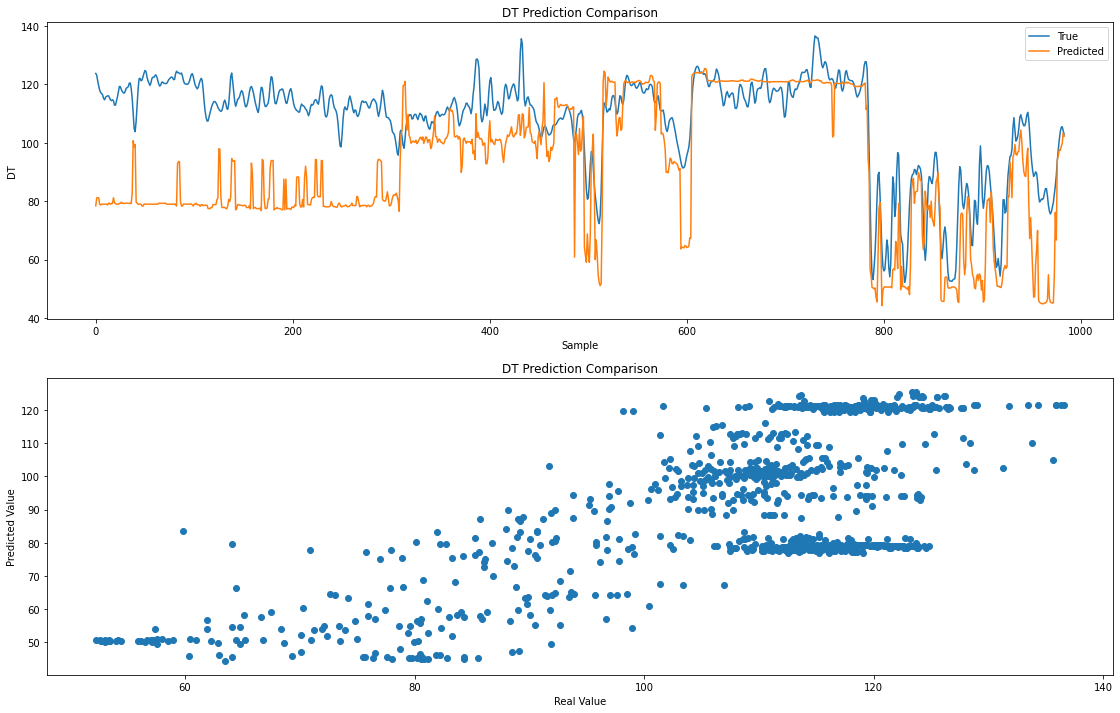

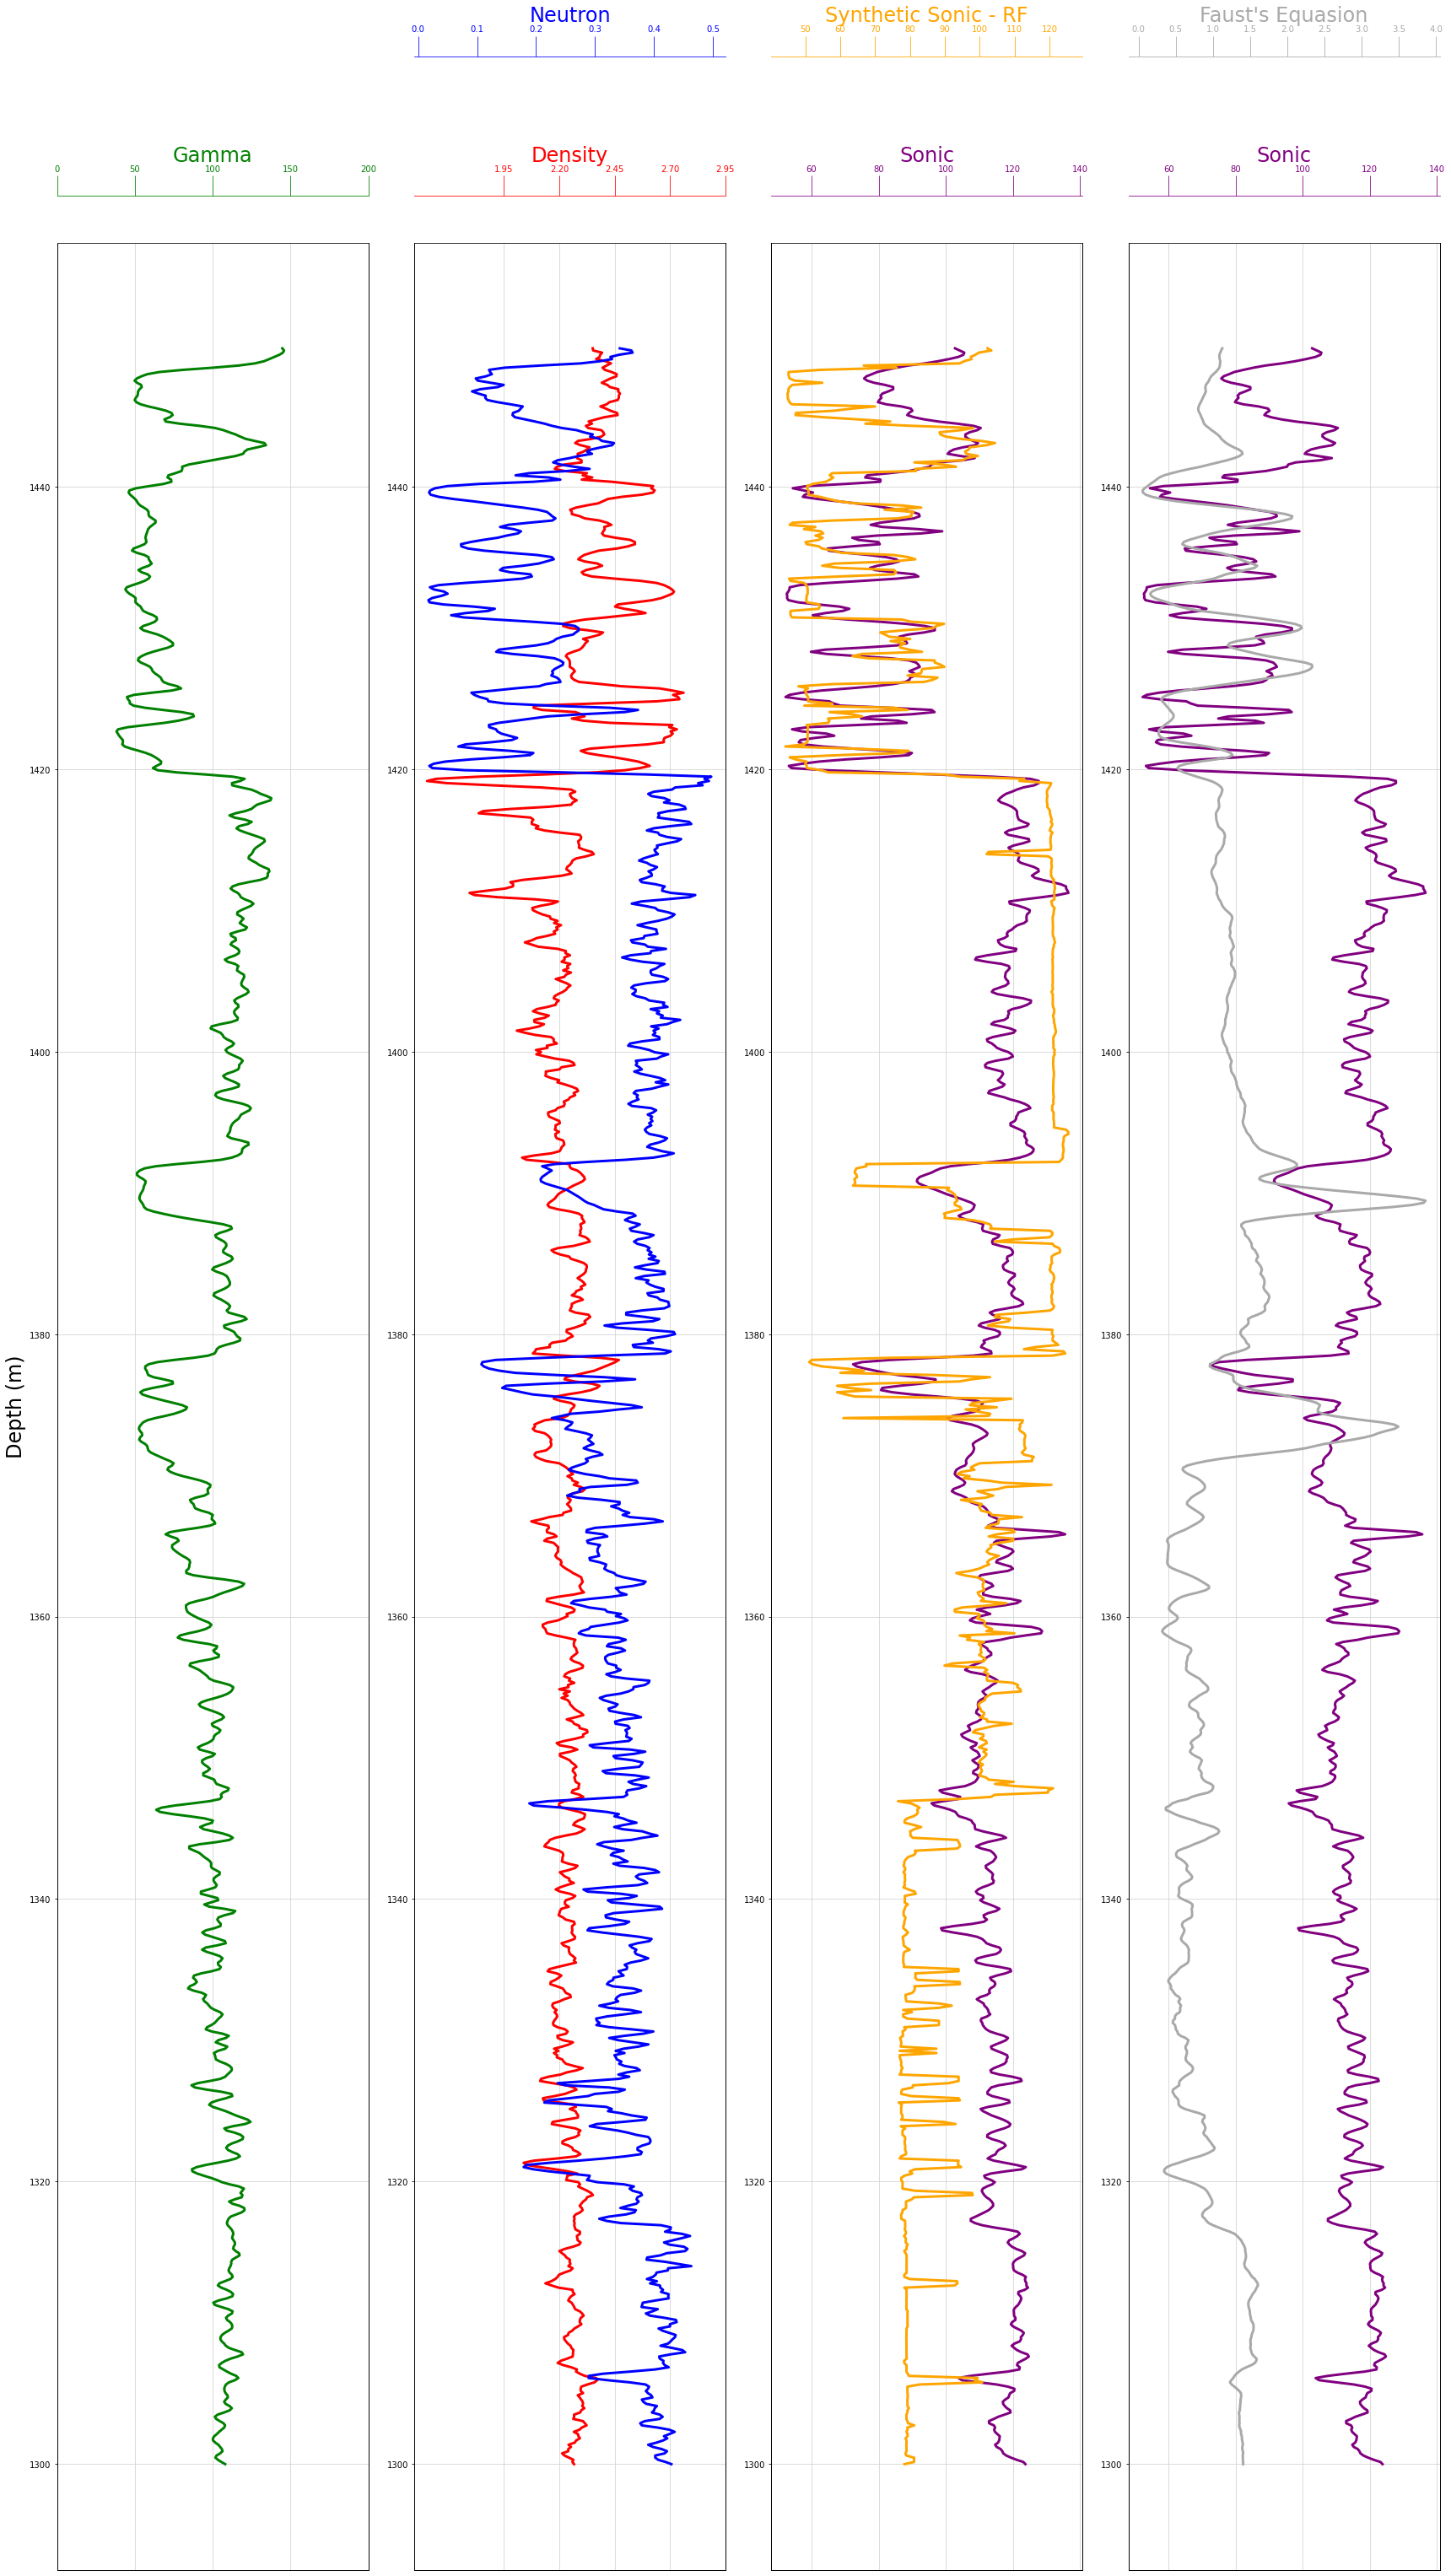

Poço: 3-LP-60-ES
Poço: 3-LP-71-ES
Poço: 4-LP-55-ES
Poço: 4-LP-86-ES
Poço: 4-LP-87-ES
Poço: 4-LP17-ES
Poço: 7-LP-11-ES
Poço: 7-LP-19-ES
Poço: 7-LP-39-ES
Poço: 7-LP-42-ES
Poço: 7-LP-63-ES


In [ ]:
statiscs = pd.DataFrame({'poco': [], 'R2': [], 'RMSE': []})

for s in range(len(df)):
    
    training_df = df[:s] + df[s+1:]

    poco = df[s]['wellName'][0]
    print('Poço:',poco)
    
    ### Concatening training Data ###
    trainingWell = pd.concat(training_df).reset_index(drop = True)
        
    ### Encoding Categorical Data ###
    labelencoder_previsores = LabelEncoder()
    trainingWell['wellName'] = labelencoder_previsores.fit_transform(trainingWell.values[:,-1])
    df[s]['wellName'] = labelencoder_previsores.fit_transform(df[s].values[:,-1])
    
    ### Defining predictors and classes on training DataSet ###
    x_trainWell = trainingWell.loc[:, trainingWell.columns != 'DT'].values
    y_trainWell  = trainingWell.loc[:, trainingWell.columns == 'DT'].values

    ### Scaling Numerical Data ###
    scaler = StandardScaler()
    x_trainWell = scaler.fit_transform(x_trainWell)

    ### Defining predictors and classes on test DataSet ###
    X_test = df[s].loc[:, df[s].columns != 'DT'].values
    y_test = df[s].loc[:, df[s].columns == 'DT'].values

    X_test = scaler.fit_transform(X_test)
    
    ### Runing prediction ###
    RF = RandomForestRegressor(n_estimators=100, random_state=100)
    grid = GridSearchCV(estimator=RF,
                        param_grid={}, 
                        scoring='r2', 
                        cv=5)
    grid.fit(x_trainWell, y_trainWell.ravel())

    well_predict = grid.best_estimator_.predict(X_test)


    if s ==0:    
        print("R²:",grid.best_score_)
        print('Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_test, well_predict))))
        result_plot(well_predict,y_test)

    ### Adding prediction and Base Line for vizualization ###
    df[s]['SYNTHETIC SONIC'] = well_predict
    df[s]['DT_F'] = 1000/((2*df[s]['DEPT']*df[s]['ILD'])*(1/3.6))
        
    if s ==0:
        wellLogPlot(df[s])
    
    ### standardizing data for next iteration ###
    df[s] = df[s].drop(columns=['SYNTHETIC SONIC','DT_F'])
    df[s]['wellName'] = poco
    
    ### creating statistics ###
    statisc = pd.DataFrame({'Well': [poco], 'R²': [grid.best_score_], 'RMSE': [np.sqrt(mean_squared_error(y_test, well_predict))]})
    statiscs = statiscs.append(statisc)

statiscs

In [ ]:
wellLogPlot(df[2])

<a class="anchor" id="seventh-bullet"></a>

[Up](#up-bullet)

## 7. References:

https://github.com/pddasig/Machine-Learning-Competition-2020/blob/master/Synthetic%20Sonic%20Log%20Generation%20Starter_Yu%202_27_2020.ipynb
    
https://github.com/andymcdgeo/Petrophysics-Python-Series/blob/master/14%20-%20Displaying%20Lithology%20Data.ipynb
    
https://github.com/andymcdgeo/Petrophysics-Python-Series/blob/master/05%20-%20Petrophysical%20Calculations.ipynb
    
https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html
    
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html